# Approximating Gaussians

One approach for approximating Gaussians is to use 'morphing' techniques as discussed by Baak et al (Baak, Gadatsch, Harrington and Verkerke, 2015), in Section 4 of this paper three morphing algorithms are compared and it is demonstrated that two of these approaches can exactly replicate Gaussian distributions. The below plot demonstrates the result of one of these algorithms, an 'integral morphing' method (Baak, Gadatsch, Harrington and Verkerke, 2015) derived by A.L.Read (Read, 1999). This method allows for a Gaussian function to be determined exactly, no matter how far apart the sigma value for the two input kernels.

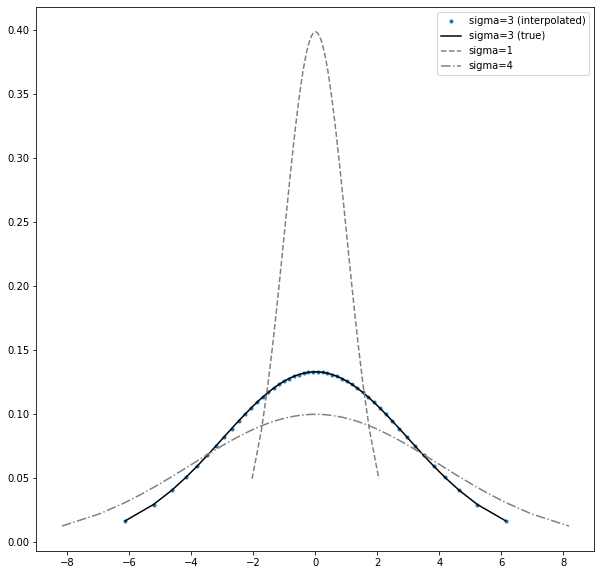

In [30]:
import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = [10, 10]

def gaussian(x, sigma=2, center=0):
    g = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return g

def gaussian_cdfinv(sigma_val, y_range):
    cdf_inv = np.sqrt(2)*sigma_val*erfinv(2*y_range-1)
    return cdf_inv

sigma_min = 1
sigma_max = 4
sigma_interp = 3

y_range = np.linspace(0, 1, 50)
cdf_inv1 = gaussian_cdfinv(sigma_min, y_range)
cdf_inv_interp = gaussian_cdfinv(sigma_interp, y_range)
cdf_inv2 = gaussian_cdfinv(sigma_max, y_range)

wt2 = (sigma_interp-sigma_min)/(sigma_max-sigma_min)
wt1 = 1-wt2

inv_interp = wt1*cdf_inv1 + wt2*cdf_inv2

g1 = gaussian(cdf_inv1, sigma=sigma_min)
g2 = gaussian(cdf_inv2, sigma=sigma_max)

g_interp = gaussian(cdf_inv_interp, sigma=sigma_interp)

interp = (g1*g2)/(wt1*g2+wt2*g1)

plt.figure()
plt.plot((wt1*cdf_inv1+wt2*cdf_inv2), interp, '.', label='sigma=3 (interpolated)')
plt.plot(cdf_inv_interp, g_interp, 'k', label='sigma=3 (true)')
plt.plot(cdf_inv1, g1, 'grey', linestyle='dashed', label='sigma=1')
plt.plot(cdf_inv2, g2, 'grey', linestyle='dashdot',label='sigma=4')
plt.legend()
plt.show()

Therefore with this method, just two Gaussian functions (at the smallest and largest sigma values) would have to be evaluated, and kernels for all other sigma values could be interpolated exactly. However, this approach would still require each input point to be convolved with the interpolated kernel and so is still computationally expensive.

To reduce computation time, a Gaussian can be approximated using a weighted linear combination of two other Gaussians. Rather than using the mixing weights to approximate individual kernels, the weights can be applied to an unbroadened spectrum, scaling it according to the sigma value at each grid point. The spectrum can then be convolved efficiently with only the kernels which have been computed exactly, and the broadened spectrums summed together. Spacing the exact Gaussian kernels regularly over the range of sigma values means that the same weights can be used between each pair of kernels.

The most straightforward way to determine weights $w_1$ and $w_2$ for the linear combination is to use linear interpolation, 
$$
\begin{align}
w_2 &= (\sigma - \sigma_{min})/(\sigma_{max}-\sigma_{min}) \\
w_1 &= 1-w_2
\end{align}
$$
with the approximated Gaussian equalling $G(x;\sigma) = w_1 G(x;\sigma_{min}) + w_2 G(x;\sigma_{max})$.

However, this does not lead to accurate approximations, particularly when the two input kernels have a wide sigma spacing. Instead of linear interpolation, the weights can be determined using least-squares optimization, which reduces the error in the approximations. Below are plots showing results for a sigma spacing of 4, 2, and $\sqrt{2}$. From these plots, it is clear that optimised interpolation is consistently more accurate than linear interpolation, with a smaller RMS Error recorded for each sigma spacing. 


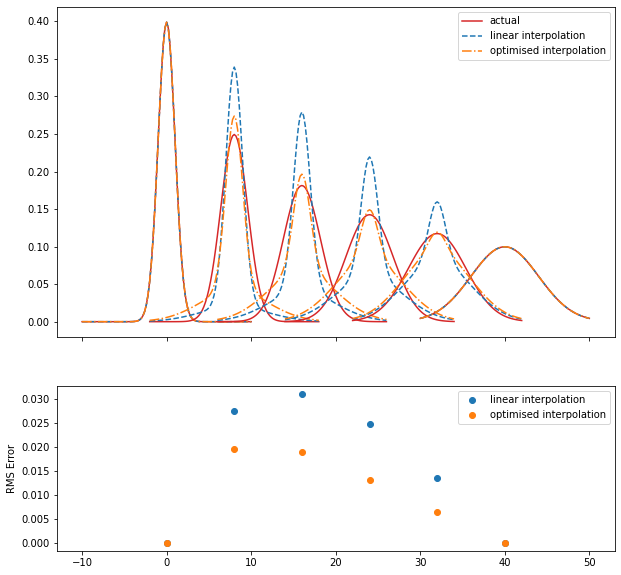

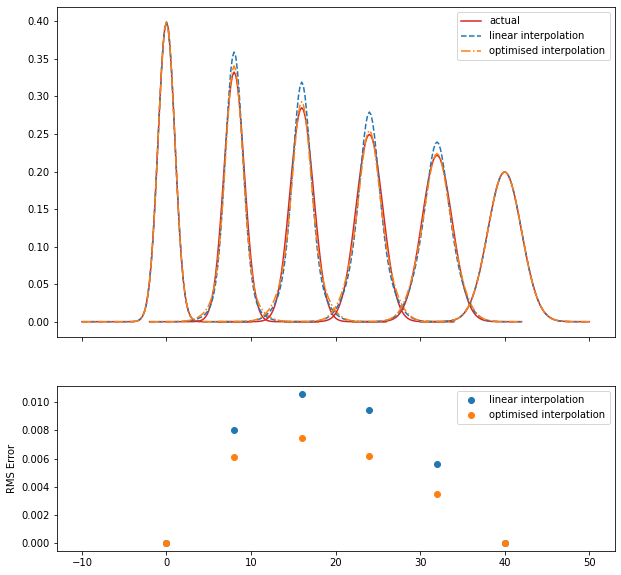

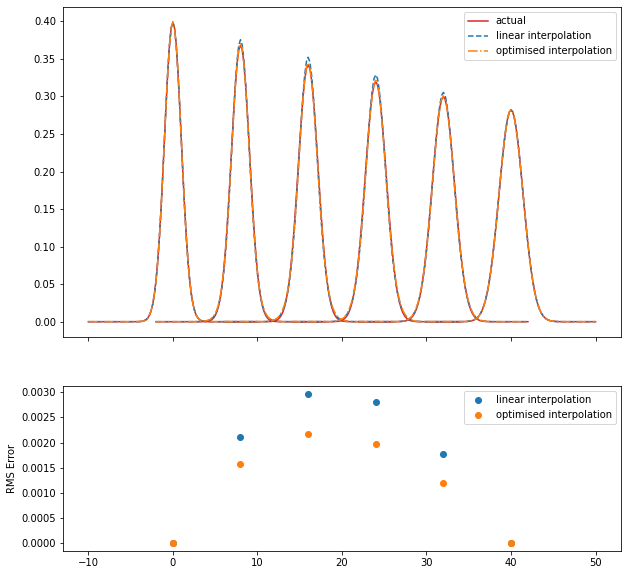

In [31]:
from scipy.optimize import curve_fit

def legend_without_duplicate_labels(ax):
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique))

def plot_linear_interp(sigma_max):
    """Plot linearly-interpolated Gaussians"""

    g1_center = 0
    g2_center = 40
    sigma_min = 1

    x = np.linspace(-10, 10, 101)
    npts = 6

    def gaussian_mix(x, w1):
        """Return a linear combination of two Gaussians with weights"""
        return (w1 * gaussian(x, sigma=sigma_min)
                + (1-w1) * gaussian(x, sigma=sigma_max))

    fig, [ax1, ax2] = plt.subplots(nrows=2,
                                   sharex=True,
                                   gridspec_kw={
                                   'height_ratios': [2, 1]})

    for sigma in np.linspace(sigma_min, sigma_max, npts):

        ydata = gaussian(x, sigma=sigma)
        mix1, _ = curve_fit(gaussian_mix, x, ydata, p0=[0.5], bounds=(0,1))
        mix1 = mix1[0]

        x_offset = (g1_center
                  + ((sigma - sigma_min)
                     * (g2_center - g1_center) / (sigma_max - sigma_min)))
        actual = gaussian(x, sigma=sigma)
        low_ref = gaussian(x, sigma=sigma_min)
        high_ref = gaussian(x, sigma=sigma_max)
        mix = (sigma - sigma_min) / (sigma_max - sigma_min)
        est = (1 - mix) * low_ref + mix * high_ref

        est_opt = gaussian_mix(x, mix1)

        ax1.plot(x + x_offset, actual, color='C3', label='actual')
        ax1.plot(x + x_offset, est, c='C0', linestyle='--', label='linear interpolation')
        ax1.plot(x + x_offset, est_opt, c='C1', linestyle='-.', label='optimised interpolation')

        legend_without_duplicate_labels(ax1)

        rms = np.sqrt(np.mean((actual - est)**2))
        rms_opt = np.sqrt(np.mean((actual - est_opt)**2))
        ax2.plot([x_offset], [rms], 'o', c='C0',label='linear interpolation')
        ax2.plot([x_offset], [rms_opt], 'o', c='C1', label='optimised interpolation')
        ax2.set_ylabel('RMS Error')

        legend_without_duplicate_labels(ax2)

plot_linear_interp(4)
plot_linear_interp(2)
plot_linear_interp(np.sqrt(2))

It is important to understand how to accuracy of the approximation changes with the chosen sigma spacing value. 

A mixture of two Gaussian functions with the same mean but different sigma produces a leptokurtic distribution, which compared to a Gaussian distribution has a more prominent peak and fatter tails. A distribution is leptokurtic if its excess kurtosis is positive, with kurtosis being defined as $3\frac{w\sigma_{min}^4 + (1-w)\sigma_{max}^4}{(w\sigma_{min}^2 + (1-w)\sigma_{min}^2)^2} - 3$, where $w$ and $1-w$ are the weights for the linear combination of the two Gaussian distributions. 

When $0<w<1$ and $\sigma>1$, the kurtosis value decreases as $\sigma$ approaches 1, and therefore the distribution produced from the linear combination becomes closer to that of a gaussian distribution. The change in kurtosis value as the sigma spacing changes can be observed in the below plots, with the top left plot showing the change in the approximated Gaussian for a particular sigma value, and the bottom left plot showing the difference between the true Gaussian and approximated Gaussian for each sigma spacing value.

Due to the spiky nature of Density of States (DOS) data, a consistent overshoot in the peak of the approximated Gaussian will be a cause of unwanted error for users, particularly when the sigma spacing is large. To avoid the inaccuracy in estimated peak height, a peak-biased least-squares optimisation can be used to fit linear combination weights. Each point along the true Gaussian (which is to be approximated) is assigned an equal weight, except for the peak, which is given a near infinite weight. As a result, the fitted curve is forced to pass through the peak of the true Gaussian. The results of this peak-biased fit are shown in the two right-hand plots of the figure below, where it can be seen that the error is reduced to close to zero at the peak, but is increased along the tails of the distribution.

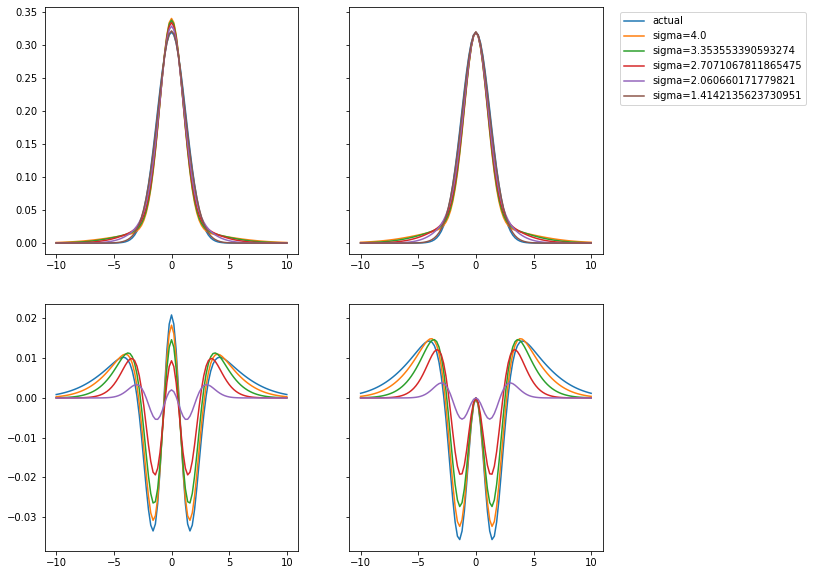

In [32]:
# plot estimated gaussians (sigma=1.25) for various sigma spacing values
sigma_spacing = np.linspace(4,np.sqrt(2),5)
x = np.linspace(-10,10,101)

sigma = 1.25
ydata = gaussian(x, sigma=sigma)

fig, axs = plt.subplots(nrows=2,ncols=2,
                               sharey='row')

axs[0,0].plot(x, ydata, label='actual')
axs[0,1].plot(x, ydata, label='actual')

sigma_min = 1

for space in sigma_spacing:
    sigma_max = space

    def gaussian_mix(x, w1):
        """Return a linear combination of two Gaussians with weights"""
        return (w1 * gaussian(x, sigma=sigma_min)
                + (1-w1) * gaussian(x, sigma=sigma_max))
    
    mix1, _ = curve_fit(gaussian_mix, x, ydata, p0=[0.5], bounds=(0,1))

    uncertainty = np.ones(len(x))
    uncertainty[50] = 1e-10

    mix3, _ = curve_fit(gaussian_mix, x, ydata, p0=mix1, bounds=(0,1), sigma = uncertainty, absolute_sigma = True)

    est = gaussian_mix(x, mix1)

    est2 = gaussian_mix(x, mix3)

    diff = (est-ydata)
    diff2 = (est2-ydata)

    axs[0,0].plot(x, est, label='sigma=' + str(space))
    axs[1,0].plot(x, diff, label='sigma=' + str(space))

    axs[0,1].plot(x, est2, label='sigma=' + str(space))
    axs[1,1].plot(x, diff2, label='sigma=' + str(space))

axs[0,1].legend(bbox_to_anchor=(1.05,1), loc='upper left')

To further understand how the error changes with sigma spacing value, the below plot shows the maximum area difference between the actual and estimated gaussian for each sigma spacing value, where the limits of integration are infinite.



Text(0, 0.5, 'Scaling for number of kernels required')

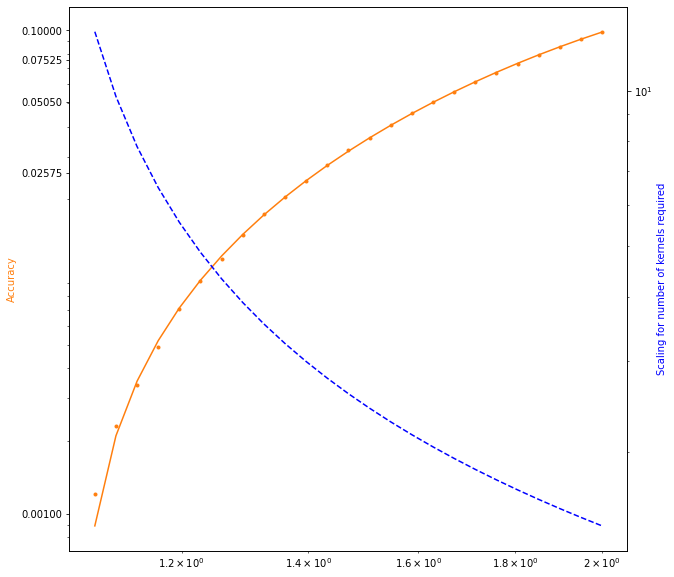

In [34]:
import math
from scipy.integrate import quad
from matplotlib.ticker import ScalarFormatter

sigma_min = 1
sigma_spacing = np.geomspace(1.08, 2, num=25)
x = np.linspace(-10,10,101)

save_space = []
save_rms1 = []
save_area1 = []
save_rms2 = []
save_area2 = []

fig, ax = plt.subplots()

for space in sigma_spacing:
    sigma_max = space
    sigma_vals = np.arange(sigma_min, sigma_max, 0.05)
    rms = np.zeros(len(sigma_vals))
    rms2 = np.zeros(len(sigma_vals))
    total_area = np.zeros(len(sigma_vals))
    total_area2 = np.zeros(len(sigma_vals))

    def gaussian_mix(x, w1):
        """Return a linear combination of two Gaussians with weights"""
        return (w1 * gaussian(x, sigma=sigma_min)
                + (1-w1) * gaussian(x, sigma=sigma_max))

    for i, sigma in enumerate(sigma_vals):
        ydata = gaussian(x,sigma=sigma)
        mix1, _ = curve_fit(gaussian_mix, x, ydata, p0=[0.5],bounds=(0,1))
        mix1=mix1[0]
        mix2 = 1-mix1
        est = gaussian_mix(x, mix1)

        #uncertainty = np.ones(len(x))
        #uncertainty[50] = 1e-10

        #mix3, _ = curve_fit(gaussian_mix, x, ydata, p0=[mix1], bounds=(0,1),
        #                    sigma=uncertainty, absolute_sigma=True)
        #mix3 = mix3[0]
        #mix4 = 1-mix3
        #est2 = gaussian_mix(x, mix3)

        def f(x, wt1,wt2):
            return  abs(math.exp(-0.5 * (x / sigma)**2) / (sigma * math.sqrt(2 * math.pi)) - \
                        (wt1*(math.exp(-0.5 * (x / sigma_min)**2) / (sigma_min * math.sqrt(2 * math.pi)))\
                        + wt2*(math.exp(-0.5 * (x / sigma_max)**2) / (sigma_max * math.sqrt(2 * math.pi)))))

        total_area[i],_ = quad(f, -np.inf, np.inf, args=(mix1,mix2))

        #total_area2[i],_ = quad(f, -np.inf, np.inf, args=(mix3,mix4))

        #rms[i] = np.sqrt(np.mean((est-ydata)**2))

        #rms2[i] = np.sqrt(np.mean((est2-ydata)**2))

    save_space.append(space)
    save_area1.append(np.max(total_area))
    #save_area2.append(np.max(total_area2))
    #save_rms1.append(np.max(rms))
    #save_rms2.append(np.max(rms2))

ax.loglog(save_space,save_area1,'.',color='C1')
#ax.loglog(save_space,save_area2, '.', color='C2', label='peak biased fit')
ax.set_yticks(np.linspace(0.001, 0.1,5))
ax.get_yaxis().set_major_formatter(ScalarFormatter())

#rms_fit = np.polyfit(save_space, save_rms1, 5)
#ax1.plot(save_space, np.polyval(rms_fit, save_space), color='C1')

#rms2_fit = np.polyfit(save_space, save_rms2, 3)
#ax1.plot(save_space, np.polyval(rms2_fit, save_space), color='C2')

area_fit = np.polyfit(save_space, save_area1, 3)
ax.plot(save_space, np.polyval(area_fit, save_space), color='C1')
ax.set_ylabel('Error', color='C1')

#area2_fit = np.polyfit(save_space, save_area2, 3)
#ax2.plot(save_space, np.polyval(area2_fit, save_space), color='C2')
#ax2.set_xticklabels(save_space)

spacing_cost = 1/np.log(save_space)
ax2 = ax.twinx()
ax2.loglog(save_space, spacing_cost,'b--')
ax2.set_ylabel('Scaling for number of kernels required',color='b')

#area2_invfit = np.polyfit(save_area2, save_space, 3)
#print(area2_invfit)


Fitting a cubic polynoimal to the inverse of the above error plot provides a function which allows an appropriate spacing value to be calculated given a desired level of accuracy. 

$spacing = 656.1*e^3 - 131.8*e^2 + 15.98*e + 1.0803$

For example, if a user would like an accuracy level of 5% (e=0.05), this corresponds to a sigma spacing value of 1.63. As the sigma spacing approaches 1, the error approaches zero. However, the computational cost also increases as the sigma spacing value decreases. The above plot illustrates how the number of kernels required to be evaluated exactly scales with the sigma spacing value, highlighting how the improved accuracy comes with the cost of decreased efficiency.

## References

- Baak, M., Gadatsch, S., Harrington, R. and Verkerke, W., 2015. Interpolation between multi-dimensional histograms using a new non-linear moment morphing method. Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment, 771, pp.39-48.

- Read, A., 1999. Linear interpolation of histograms. Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment, 425(1-2), pp.357-360.